# **Inside Logistic Regression: A Step-by-Step Guide with Titanic as a Case Study**

### **Libraries used**

In [1]:
import math
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder

from statistics import mean
from collections import defaultdict
from typing import List, Dict, Literal

from scratch.complex_typing import Vector
from scratch.metrics import precision, recall, f1_score, print_classification_report

### **Introduction**

Logistic regression is a fundamental classification algorithm widely used in statistics, machine learning, and data science. Unlike linear regression, which predicts continuous values, logistic regression estimates the probability that a given input belongs to a particular class. It serves as the foundation for more complex models such as neural networks and generalized linear models, making it an essential concept for practitioners and researchers alike.

This notebook presents a complete implementation of logistic regression from scratch, focusing on the mathematical foundations and algorithmic processes that define the model. We will explore the logistic function, the log-likelihood objective, and the optimization process used to find the best parameters through gradient ascent.

As a practical application, we will use the Titanic dataset — a classic and publicly available dataset — to predict passenger survival based on features such as age, class, and sex. This example offers a compelling context for exploring the real-world performance of logistic regression and demonstrates the full workflow from data preparation to model evaluation.

By the end of this notebook, readers will gain a clear conceptual and practical understanding of how logistic regression works internally, how to implement it, and how to evaluate its performance using standard classification metrics.

### **Theoretical framework**

**Logistic regression**

Logistic regression is a supervised learning algorithm used for binary classification tasks. At its core, it models the probability that a sample belongs to the positive class using the logistic (sigmoid) function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

where $z = \beta_0 + \beta_1 x_1 + \cdots + \beta_n x_n$ is the linear combination of the input features and their associated parameters (coefficients). This function ensures the output values lie between 0 and 1, which makes them interpretable as probabilities.

To fit the model, we aim to maximize the likelihood of observing the actual data, given the model parameters. This is commonly done by maximizing the log-likelihood function using gradient ascent. The derivative of this function with respect to each parameter (i.e., the gradient) guides the update of the parameters at each iteration.

**Gradient and Gradient Ascent in Logistic Regression**

*The gradient*

In logistic regression, our goal is to find the best parameters (also called coefficients) that allow our model to correctly predict the probability that a given input belongs to class 1 (usually represented as y = 1).

To do this, we use something called the log-likelihood function. This function tells us how likely it is that our model, with its current parameters, would have produced the actual labels in the data. The higher the likelihood, the better our model fits the data.

We use the sigmoid function (explained before), denoted by $\sigma(z)$, to convert the linear combination of inputs into a probability:

*Log-Likelihood Function*

For a single training example $(\mathbf{x}_i, y_i)$, the probability of the outcome under the model is:

$$
P(y_i \mid \mathbf{x}_i) = \sigma(z_i)^{y_i} (1 - \sigma(z_i))^{1 - y_i}
$$

Taking the logarithm (to make the math easier and more stable), we get the log-likelihood for all the training examples:

$$
\mathcal{L}(\boldsymbol{\beta}) = \sum_{i=1}^{m} \left[ y_i \log(\sigma(z_i)) + (1 - y_i) \log(1 - \sigma(z_i)) \right]
$$

This is the function we want to maximize.

*The Gradient Ascent*

To maximize the log-likelihood, we use an optimization method called gradient ascent. The idea is simple: we compute the gradient (the direction in which the log-likelihood increases the fastest), and then take small steps in that direction.

The formula for updating the parameters is:

$$
\boldsymbol{\beta} \leftarrow \boldsymbol{\beta} + \eta \cdot \nabla \mathcal{L}(\boldsymbol{\beta})
$$

Where:
- $\eta$ is the learning rate (how big each step is),
- $\nabla \mathcal{L}(\boldsymbol{\beta})$ is the gradient, a vector that tells us how much each coefficient should change.

Each partial derivative in the gradient is:

$$
\frac{\partial \mathcal{L}}{\partial \beta_j} = \sum_{i=1}^{m} \left( y_i - \sigma(z_i) \right) x_{ij}
$$

In words, the update for each coefficient depends on the difference between the actual label and the predicted probability, multiplied by the value of the input feature. This tells us whether to increase or decrease the coefficient.

**Data Preparation and Preprocessing**

Proper data preparation is critical for building a robust and generalizable model. One of the most important principles in machine learning is to simulate real-world prediction scenarios, where the model must generalize to unseen data. Therefore, the first step must always be to split the dataset into training and testing sets.

No transformation (including imputation, encoding, or normalization) should be applied before this split. Applying transformations before splitting would lead to data leakage, where information from the test set influences the training process, resulting in overly optimistic performance estimates.

Once the dataset is split, we apply the following preprocessing steps separately on each subset, ensuring that the transformations learned from the training data are reused (not re-fitted) on the test data.

1. Imputation of Missing Values

Real-world data often contains missing entries. These must be handled carefully to maintain the model’s integrity. We fit an imputation strategy (e.g., replacing missing values with the mean or median) on the training set only and then apply that strategy to both training and testing data. This avoids using information from the test set that would otherwise bias model evaluation.

2. Encoding Categorical Variables

Categorical features need to be converted to numerical format for use in logistic regression. We use one-hot encoding (i.e., dummy variables) to achieve this. As with imputation, the encoder is fit on the training data and applied identically to the test data to ensure consistency in the number and order of resulting features.

3. Normalization

Because logistic regression relies on gradient-based optimization, features should be on a similar scale to improve convergence and interpretability. We standardize the numerical features by removing the mean and scaling to unit variance, using statistics (mean and standard deviation) computed from the training set. These parameters are then used to transform the test set.

**Why These Steps Matter**

Each transformation—imputation, encoding, and normalization—is essential for ensuring the quality and fairness of the model. More importantly, applying these transformations after splitting the data preserves the integrity of the testing process. Any leakage of information from the test set into the training phase can result in models that overfit and perform poorly on unseen data.

In the next section, we will apply this pipeline while implementing logistic regression from scratch using the Titanic dataset.

### **Practical example**

To begin our practical implementation, we first need to load the dataset. In this case, we will use the famous Titanic dataset, which contains information about the passengers aboard the Titanic, including features such as age, sex, ticket class, and whether or not they survived. This dataset is commonly used for binary classification tasks, making it an ideal candidate for our logistic regression model.

We will load the dataset using pandas, which provides a simple and efficient way to handle structured data in Python. Once loaded, we will take a quick look at the structure of the dataset to better understand the features and identify any preprocessing steps that may be necessary.

In [2]:
df_raw = pd.read_csv('datasets/titanic_dataset.csv')
df_adjusted = df_raw.copy()

In [3]:
def summary(df):
    """
    Prints a detailed summary of each column in a pandas DataFrame.
    Shows type, missing values, and descriptive statistics for each column.
    """
    print(f"\nDataFrame Summary: {df.shape[0]} rows, {df.shape[1]} columns")
    print("=" * 60)

    for col in df.columns:
        print(f"\nColumn: {col}")
        print(f"Type: {df[col].dtype}")
        print(f"Missing values: {df[col].isna().sum()}")

        if pd.api.types.is_numeric_dtype(df[col]):
            print(f"Mean: {df[col].mean():.5f}")
            print(f"Median: {df[col].median():.5f}")
            print(f"Min: {df[col].min():.5f}")
            print(f"Max: {df[col].max():.5f}")
            print(f"Standard Deviation: {df[col].std():.5f}")
        elif pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            print("Value counts:")
            print(df[col].value_counts())
        elif pd.api.types.is_bool_dtype(df[col]):
            print("Value counts:")
            print(df[col].value_counts())
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            print(f"Min date: {df[col].min():.5f}")
            print(f"Max date: {df[col].max():.5f}")
        else:
            print("Unrecognized or complex data type.")

    print("\n" + "=" * 60 + "\nEnd of summary.\n")

In [4]:
summary(df_raw)


DataFrame Summary: 891 rows, 12 columns

Column: PassengerId
Type: int64
Missing values: 0
Mean: 446.00000
Median: 446.00000
Min: 1.00000
Max: 891.00000
Standard Deviation: 257.35384

Column: Survived
Type: int64
Missing values: 0
Mean: 0.38384
Median: 0.00000
Min: 0.00000
Max: 1.00000
Standard Deviation: 0.48659

Column: Pclass
Type: int64
Missing values: 0
Mean: 2.30864
Median: 3.00000
Min: 1.00000
Max: 3.00000
Standard Deviation: 0.83607

Column: Name
Type: object
Missing values: 0
Value counts:
Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick           

/var/folders/8f/z7k3sy6x0l555p2rqjf6zvtr0000gn/T/ipykernel_16011/604072689.py:20: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):


The Titanic dataset consists of 891 passenger records and 12 columns, capturing a mix of numerical and categorical features. The target variable is Survived, a binary indicator of whether a passenger survived (1) or not (0), with a survival rate of approximately 38% in the dataset.

Among the numerical variables, we find:
	•	Age, which ranges from 0.42 to 80 years but contains 177 missing values.
	•	Fare, ranging from 0 to 512.33, shows high variance.
	•	SibSp and Parch represent family relations aboard and have skewed distributions toward lower values.

The categorical features include:
	•	Sex, with a distribution of 577 males and 314 females.
	•	Embarked, the port of embarkation, has 2 missing values.
	•	Cabin, which has significant missing data (687 values) and complex formatting, will require special treatment or exclusion.
	•	Ticket and Name are high-cardinality text fields and may not contribute directly without further feature engineering.

Overall, this dataset requires preprocessing steps such as imputation of missing values, encoding categorical variables, and scaling numerical features before it is ready for training a logistic regression model.

Before applying any machine learning models, it’s crucial to clean and organize the dataset. The next code performs several essential preprocessing steps to prepare the Titanic dataset for training:

1. Standardizing column names:

The column names are converted to lowercase, stripped of leading/trailing whitespace, and spaces are replaced with underscores. This makes them easier to handle programmatically and avoids potential errors in later steps.

2. Selecting relevant features:

The dataset is reduced to a subset of columns that will be used in the model. These include:
- Numerical predictors: age, sibsp, parch, fare
- Categorical predictors: pclass, sex, embarked
- Target variable: survived

3.	Splitting the dataset:

The cleaned dataset is divided into training (80%) and testing (20%) sets using train_test_split. This separation is crucial to evaluate the model’s performance on unseen data and to avoid overfitting.

4.	Keeping a copy of the original data:

Backups of the original training and testing sets are stored so we can always refer back to the unprocessed version during further transformations or analysis.
    
These steps set a solid foundation for data imputation, encoding, and modeling, ensuring reproducibility and cleaner downstream code.

In [5]:
# Standarize columns names
df_adjusted.columns = [col_name.strip().lower().replace(" ","_") for col_name in df_adjusted.columns]

# Define predictors and targets
predictors_num = ['age', 'sibsp', 'parch','fare']
predictors_cat = ['pclass', 'sex', 'embarked']
target = 'survived'
df_adjusted = df_adjusted[predictors_num + predictors_cat + [target]]

# Train/test split
train_data, test_data= train_test_split(df_adjusted, test_size=0.2, random_state=42)
train_data_original = train_data.copy()
test_data_original = test_data.copy()


At this stage, our dataset has already been split into training and testing sets. However, we still need to perform three key transformations to prepare the data for modeling:
- Imputation: Filling in missing values (specifically in Age and Embarked).
- Encoding: Converting categorical variables into dummy/indicator variables.
- Normalization: Scaling numerical features to a standard range.

Having explored the internal mechanisms behind these preprocessing techniques in previous notebooks, we now move on to applying scikit-learn’s built-in tools to carry out essential data transformations.

It is crucial that we apply these transformations consistently:
- We fit the imputers and scalers only on the training data.
- We then apply the same parameters (learned from training) to transform the test data.

This ensures that no information from the test set leaks into the training process, preserving the integrity of our model evaluation. We’ll start by creating custom imputers specifically for the Age and Embarked columns.

**Imputation**

To address missing values in our dataset, we apply two distinct imputation strategies tailored to the characteristics of the variables:

1. KNN Imputer (for Embarked)

The Embarked column contains categorical data with a few missing entries. Instead of using a simple strategy like most frequent value, we opt for a more nuanced method: the K-Nearest Neighbors (KNN) imputer.

This technique fills in missing values based on the values of the k-nearest complete rows, using a distance metric (often Euclidean for numerical features). In our context, the KNN imputer uses the similarity between rows (based on other features like Pclass, Sex, etc.) to infer the most appropriate value for Embarked.

This strategy allows for data-aware imputations that consider the relationship between features, often resulting in better estimates than simpler approaches.

2. Group-Based Imputer (for Age)

The Age column is a continuous numerical feature with more missing entries and considerable variability. Using a constant mean or KNN may not be ideal, especially if Age depends on other variables like Pclass or Sex.

We therefore define a custom imputer using a GroupByImputer class. It works as follows:
- It groups rows using one or more specified columns (e.g., Pclass, Sex).
- For each group, it calculates an aggregate value (e.g., the mean age).
- Missing values are filled based on the group to which the row belongs.

This approach provides context-sensitive imputations, preserving relationships between features and improving model quality.

In [6]:
class GroupByImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_col, agg='mean'):
        self.group_cols = group_cols
        self.target_col = target_col
        self.agg = agg

    def fit(self, X, y=None):
        self.fill_values_ = (
            X.groupby(self.group_cols)[self.target_col]
            .agg(self.agg)
            .to_dict()
        )
        return self

    def transform(self, X):
        X = X.copy()
        def get_fill_value(row):
            key = tuple(row[col] for col in self.group_cols)
            return self.fill_values_.get(key, X[self.target_col].mean())
        
        mask = X[self.target_col].isnull()
        X.loc[mask, self.target_col] = X[mask].apply(get_fill_value, axis=1)
        return X

*Train dataset*

In [7]:
# Apply the imputer we code before for getting ages considering agreggations in "sex" and "pclass"
age_imputer = GroupByImputer(group_cols=['sex','pclass'], target_col='age', agg = 'mean')
age_imputer.fit(train_data)
train_data = age_imputer.transform(train_data)

# Apply a knn imputer for "embarked" this is already available in sklearn modules
# Input embarked
col_to_inpute = 'embarked'
le = LabelEncoder()
not_nan_mask = train_data[col_to_inpute].notna()
le.fit(train_data.loc[not_nan_mask, col_to_inpute])
train_data.loc[not_nan_mask, col_to_inpute] = le.transform(train_data.loc[not_nan_mask, col_to_inpute])

# Convert to float
train_data[col_to_inpute] = train_data[col_to_inpute].astype(float)

# Apply KNN imputer
knn_imputer = KNNImputer(n_neighbors=2)
columns = predictors_num + [col_to_inpute]
knn_imputer.fit(train_data[columns])
imputed = knn_imputer.transform(train_data[columns])

# Replace the encoded column
train_data[col_to_inpute] = imputed[:, columns.index(col_to_inpute)]

# Decode back to original string labels
train_data[col_to_inpute] = train_data[col_to_inpute].round().astype(int)
train_data[col_to_inpute] = le.inverse_transform(train_data[col_to_inpute])


*Test dataset* - We use the imputers fitted with the training dataset

In [8]:
# Apply the imputer we code before - We still using the one fitted in train dataset
test_data = age_imputer.transform(test_data)

# Apply a knn imputer for "embarked" this is already available in sklearn modules
# Input embarked
col_to_inpute = 'embarked'
not_nan_mask = test_data[col_to_inpute].notna()
test_data.loc[not_nan_mask, col_to_inpute] = le.transform(test_data.loc[not_nan_mask, col_to_inpute])

# Convert to float
test_data[col_to_inpute] = test_data[col_to_inpute].astype(float)

# Apply KNN imputer
columns = predictors_num + [col_to_inpute]
imputed = knn_imputer.transform(test_data[columns])

# Replace the encoded column
test_data[col_to_inpute] = imputed[:, columns.index(col_to_inpute)]

# Decode back to original string labels
test_data[col_to_inpute] = test_data[col_to_inpute].round().astype(int)
test_data[col_to_inpute] = le.inverse_transform(test_data[col_to_inpute])

**Encoding variables for categorical predictors (dummies variables)**

One-hot encoding transforms each categorical variable into multiple binary (0/1) columns—one for each unique category. For example, the Sex variable with two possible values (male, female) would be transformed into two columns:
- Sex_male: 1 if the passenger is male, 0 otherwise.
- Sex_female: 1 if the passenger is female, 0 otherwise.

This representation ensures that:
- The model does not assume any ordinal relationship between categories.
- Each category is treated independently by the algorithm.

To avoid multicollinearity (where one variable is perfectly correlated with others), it’s common practice to drop one dummy column per categorical variable. This doesn’t cause any loss of information because the dropped category can always be inferred from the remaining ones.

In our implementation, we won't drop a variable but **it's important for you to know that this could help**.

*Train dataset*

In [9]:
train_data = pd.get_dummies(train_data, columns=predictors_cat)
train_data = train_data.replace({True: 1, False: 0})

# Reordenar las columnas: target al final
train_data = train_data[[c for c in train_data.columns if c != target] + [target]]

/var/folders/8f/z7k3sy6x0l555p2rqjf6zvtr0000gn/T/ipykernel_16011/2462639932.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data = train_data.replace({True: 1, False: 0})


*Test dataset*

In [10]:
# Get dummies
test_data = pd.get_dummies(test_data, columns=predictors_cat)
test_data = test_data.replace({True: 1, False: 0})

# Reordenar las columnas: target al final
test_data = test_data[[c for c in test_data.columns if c != target] + [target]]

/var/folders/8f/z7k3sy6x0l555p2rqjf6zvtr0000gn/T/ipykernel_16011/2626425710.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data = test_data.replace({True: 1, False: 0})


**Normalization for numerical variables**

Normalization is a crucial preprocessing step when working with numerical features in machine learning models like logistic regression. Its purpose is to standardize the scale of features so that each has a mean of 0 and a standard deviation of 1 (when using StandardScaler). This helps gradient-based algorithms converge more efficiently and prevents features with larger numerical ranges from dominating the optimization process.

In our case, we apply normalization only to continuous numerical variables such as:
- age
- sibsp
- parch
- fare

These features can vary significantly in scale, so normalization ensures that the model treats them more equally during training.

Important: Dummy variables (created from categorical features like sex, pclass, and embarked) should not be normalized. These binary indicators (0 or 1) represent category membership. Scaling them would distort their meaning and interfere with the model’s interpretation of category presence. Therefore, we exclude them from the normalization process.

By carefully separating numerical and categorical features during preprocessing, we ensure that each transformation is applied only where it makes sense, maintaining data integrity and improving model performance.

*Train dataset*

In [11]:
# Columns to standardize
cols_to_scale = predictors_num

# Build transformer
standar_scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'  # keep other columns (e.g. 'gender') untouched
)

# Transform the data
standar_scaler.fit(train_data)
data_scaled = standar_scaler.transform(train_data)

# Get correct column order and names
new_columns = cols_to_scale + [col for col in train_data.columns if col not in cols_to_scale]
train_data = pd.DataFrame(data_scaled, columns=new_columns)

*Test dataset* - Apply the standard scaler fitted with the training dataset

In [12]:
# Normalization - We still using the one fitted in train
data_scaled = standar_scaler.transform(test_data)

# Get correct column order and names
new_columns = cols_to_scale + [col for col in test_data.columns if col not in cols_to_scale]
test_data = pd.DataFrame(data_scaled, columns=new_columns)

**Our final data**

Finally we get our final X_train, y_train, X_test and y_test data

In [13]:
final_predictors = [col for col in train_data.columns if col!='survived']
final_target = 'survived'

# Training data
X_train = train_data[final_predictors]
y_train = train_data[final_target]

# Testing data
X_test = test_data[final_predictors]
y_test = test_data[final_target]

**Implementing Logistic Regression from Scratch**


To deepen our understanding of how logistic regression works, we will now implement the model from scratch—without relying on external libraries like scikit-learn. This hands-on approach allows us to explore the internal mechanics of the algorithm, including how the model learns from data through gradient ascent and how the sigmoid function maps linear combinations into probabilities.

The LogisticRegressionScratch class below encapsulates the full implementation of a binary logistic regression classifier. Its key features include:
- Parameter Initialization: Random initialization of model coefficients (self.betas).
- Training (fit method): Uses gradient ascent to maximize the log-likelihood of the data.
- Prediction: Computes class probabilities using the logistic (sigmoid) function and returns binary predictions based on a threshold.
- Gradient Calculation and Update: At each iteration, the model computes the partial derivatives of the log-likelihood function with respect to each coefficient—this is the gradient. Then, it updates the coefficients by taking a step in the direction of the gradient (gradient ascent), since we are maximizing the log-likelihood function. This process continues iteratively, gradually adjusting the coefficients to improve the model’s fit.
- Probabilistic Objective Function: Tracks the model’s performance using the product of predicted probabilities (a form of the log-likelihood).

This implementation reinforces essential machine learning concepts such as:
- The role of gradients in optimization,
- The probabilistic interpretation of logistic regression,

In practice, for real-world applications we typically rely on highly optimized libraries like scikit-learn, but building this from the ground up offers critical intuition for what those libraries are doing internally.

In [14]:
class LogisticRegressionScratch:
    """ 
    A model to represent a logistic regression
    """

    def __init__(self):
        """ 
        Initialize the attributes needed
        """
        self.betas = []
        self.learning_rate = None
        self.epochs = None
        
    def fit(self,
            X: List[Vector], 
            y: Vector, 
            learning_rate: float = 0.001, 
            epochs: int = 1000) -> None:
        """ 
        A method to train the model
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.betas = [random.random() for _ in range(len(X[0]) + 1)]
        pbar = tqdm.tqdm(range(self.epochs), "Training model")
        for epoch in pbar:
            gradient = np.mean([self._gradient([1] + xi, yi) for xi, yi in zip(X,y)], axis=0)
            new_betas = self._gradient_step(gradient)
            self.betas = new_betas
            prob = self._prob(X, y)
            pbar.set_postfix({"prob": f"{prob:.4f}"})
    
    def _prob(self, X: List[Vector], y: Vector) -> float:
        """ 
        Computes the function result we are maximizing
        """
        probabilities = []
        for x_i,y_i in zip(X, y):
            probability = (self._logistic([1] + x_i)**y_i)*((1 - self._logistic([1] + x_i))**(1-y_i))
            probabilities.append(probability)
        
        return np.mean(probabilities).item()
    
    def _gradient_step(self, gradient: Vector)-> Vector:
        """ 
        Make a step in the direction to maximize the function
        """
        return [self.betas[i] + (self.learning_rate*gradient[i]) for i in range(len(self.betas))]
    
    def predict(self, x: Vector, threshold: float = 0.5) -> float:
        """ 
        Method to predict
        """
        z = np.dot(self.betas, [1] + x)
        return 1 if 1/(1 + math.exp(-z)) >= threshold else 0
    
    def _logistic(self, x: Vector) -> float:
        """ 
        Return f(x) -> logistic function
        """
        z = np.dot(self.betas, x)
        return 1/(1 + math.exp(-z))
    
    def _logistic_derivative(self, x:Vector) -> float:
        """ 
        Returns the derivative of the logistic function
        """
        return self._logistic(x) * (1 - self._logistic(x))
    
    def _gradient(self, x:Vector, y:float) -> Vector:
        """ 
        Return the gradient of a point
        The objective function is the probability
        """
        gradient = [
             (y - self._logistic(x))*x[i] for i in range(len(self.betas))
        ]
        return gradient
    

To evaluate the performance of a classification model, especially in multi-class or imbalanced datasets, it is essential to go beyond basic accuracy. The following implementation provides a detailed computation of the confusion matrix and associated metrics such as precision, recall, and F1-score. It supports both binary and multi-class classification problems, with optional aggregation strategies for the latter.

Let's code our metrics functions.

In [15]:
# Our metrics report
def cmatrix(y_true: Vector, y_pred: Vector) -> Dict[str, float]:
    """ Get the confusion matrix of each label
        Cols - Predicted
        Rows - Actual
    """
    real_labels = y_true
    predicted_labels = y_pred
    labels = sorted(list(set(real_labels + predicted_labels)), reverse=True)
    cm = confusion_matrix(real_labels, predicted_labels, labels=labels)
    
    cm_detailed = defaultdict(dict)
    for label_index in range(len(labels)):
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        for row in range(len(labels)):
            for col in range(len(labels)):
                if row==label_index and col==label_index:
                    tp += int(cm[row][col])
                elif row==label_index and col!=label_index:
                    fn += int(cm[row][col])
                elif row!=label_index and col==label_index:
                    fp += int(cm[row][col])
                elif row!=label_index and col!=label_index:
                    tn += int(cm[row][col])

        cm_detailed[labels[label_index]]['tp'] = tp
        cm_detailed[labels[label_index]]['tn'] = tn
        cm_detailed[labels[label_index]]['fp'] = fp
        cm_detailed[labels[label_index]]['fn'] = fn

    return labels, cm, cm_detailed

def metrics(y_true: Vector, y_pred: Vector, kind: Literal['micro','macro'] = 'micro') -> Dict[str, float]:
    labels, cm, cm_detailed = cmatrix(y_true, y_pred)
    # If just two labels we get the simpler confusion matrix and got metrics
    if len(labels) == 2:
        tp = cm_detailed[labels[0]]['tp']
        fp = cm_detailed[labels[0]]['fp']
        fn = cm_detailed[labels[0]]['fn']
        tn = cm_detailed[labels[0]]['tn']
        _accuracy = float(np.trace(cm)/np.sum(cm))
        _precision = precision(tp, fp)
        _recall = recall(tp, fn)
        _f1_score = f1_score(tp, tn, fp, fn)

        return {
            "labels": labels,
            "confusion_matrix": cm,
            "confusion_matrix_detailes": cm_detailed,
            "accuracy": _accuracy, 
            "precision": _precision, 
            "recall": _recall,
            "f1_score": _f1_score
        }
    
    # If multilabeled predictions we got micro or macro metrics
    if len(labels) > 2:
        _accuracy = float(np.trace(cm)/np.sum(cm))
        if kind == 'micro':
            tp = sum([cm_detailed[label]['tp'] for label in labels])
            fp = sum([cm_detailed[label]['fp'] for label in labels])
            fn = sum([cm_detailed[label]['fn'] for label in labels])
            tn = sum([cm_detailed[label]['tn'] for label in labels])
            _precision = precision(tp, fp)
            _recall = recall(tp, fn)
            _f1_score = f1_score(tp, tn, fp, fn)

        elif kind == 'macro':
            _precision = mean(
                [
                    precision(
                        cm_detailed[label]['tp'],
                        cm_detailed[label]['fp']
                    )
                    for label in labels
                ]
            
            )

            _recall = mean(
                [
                    recall(
                        cm_detailed[label]['tp'],
                        cm_detailed[label]['fn']
                    )
                    for label in labels
                ]
            
            )

            _f1_score = mean(
                [
                    f1_score(
                        cm_detailed[label]['tp'],
                        cm_detailed[label]['tn'],
                        cm_detailed[label]['fp'],
                        cm_detailed[label]['fn']
                    )
                    for label in labels
                ]
            
            )

        else:
            raise AssertionError('Not a valid kind of metrics, use kind = "micro" or kind = "macro"')
        
        return {
            "labels": labels,
            "confusion_matrix": cm,
            "confusion_matrix_detailes": cm_detailed,
            "accuracy": _accuracy, 
            "precision": _precision, 
            "recall": _recall,
            "f1_score": _f1_score
        }

def metrics(y_true: Vector, y_pred: Vector, kind: Literal['micro','macro'] = 'micro') -> Dict[str, float]:
    labels, cm, cm_detailed = cmatrix(y_true, y_pred)
    # If multilabeled predictions we got micro or macro metrics
    if len(labels) > 0:
        _accuracy = float(np.trace(cm)/np.sum(cm))
        if kind == 'micro':
            tp = sum([cm_detailed[label]['tp'] for label in labels])
            fp = sum([cm_detailed[label]['fp'] for label in labels])
            fn = sum([cm_detailed[label]['fn'] for label in labels])
            tn = sum([cm_detailed[label]['tn'] for label in labels])
            _precision = precision(tp, fp)
            _recall = recall(tp, fn)
            _f1_score = f1_score(tp, tn, fp, fn)

        elif kind == 'macro':
            _precision = mean(
                [
                    precision(
                        cm_detailed[label]['tp'],
                        cm_detailed[label]['fp']
                    )
                    for label in labels
                ]
            
            )

            _recall = mean(
                [
                    recall(
                        cm_detailed[label]['tp'],
                        cm_detailed[label]['fn']
                    )
                    for label in labels
                ]
            
            )

            _f1_score = mean(
                [
                    f1_score(
                        cm_detailed[label]['tp'],
                        cm_detailed[label]['tn'],
                        cm_detailed[label]['fp'],
                        cm_detailed[label]['fn']
                    )
                    for label in labels
                ]
            
            )

        else:
            raise AssertionError('Not a valid kind of metrics, use kind = "micro" or kind = "macro"')
        
        return {
            "labels": labels,
            "confusion_matrix": cm,
            "confusion_matrix_detailes": cm_detailed,
            "accuracy": _accuracy, 
            "precision": _precision, 
            "recall": _recall,
            "f1_score": _f1_score
        }


**Training the model**

In [16]:
model = LogisticRegressionScratch()
model.fit(np.array(X_train).tolist(), np.array(y_train).tolist(), epochs=10000, learning_rate=0.01)

Training model: 100%|██████████| 10000/10000 [03:51<00:00, 43.13it/s, prob=0.7149]


**Metrics**

*Report in training data*

In [17]:
y_pred = [model.predict(x) for x in np.array(X_train).tolist()]
train_macro_metrics = metrics(np.array(y_train).tolist(), y_pred, kind='macro')

In [18]:
print("Train Macro Metrics")
print_classification_report(train_macro_metrics)

Train Macro Metrics

=== Classification Report ===
Labels: [1.0, 0.0]

Confusion Matrix:
  182  86
  49  395

Detailed Confusion Metrics per Class:
  1.0          -> TP: 182, TN: 395, FP: 49, FN: 86
  0.0          -> TP: 395, TN: 182, FP: 86, FN: 49

Overall Metrics:
  Accuracy : 0.8104
  Precision: 0.8045
  Recall   : 0.7844
  F1 Score : 0.7918


*Report in testing data*

In [20]:

y_pred = [model.predict(x) for x in np.array(X_test).tolist()]
test_macro_metrics = metrics(np.array(y_test).tolist(), y_pred, kind='macro')

In [21]:
print("Test Macro Metrics")
print_classification_report(test_macro_metrics)

Test Macro Metrics

=== Classification Report ===
Labels: [1.0, 0.0]

Confusion Matrix:
  53  21
  14  91

Detailed Confusion Metrics per Class:
  1.0          -> TP: 53, TN: 91, FP: 14, FN: 21
  0.0          -> TP: 91, TN: 53, FP: 21, FN: 14

Overall Metrics:
  Accuracy : 0.8045
  Precision: 0.8018
  Recall   : 0.7914
  F1 Score : 0.7952


The logistic regression model implemented from scratch demonstrated solid classification performance on the test dataset. With an accuracy of 80.45%, the model correctly predicted the target class in the majority of cases. The macro-averaged metrics indicate a balanced performance across both classes:
- Precision: 80.18% – When the model predicts a positive case, it’s correct about 80% of the time.
- Recall: 79.14% – The model correctly identifies around 79 out of every 100 actual positive cases.
- F1 Score: 79.52% – This reflects a solid balance between precision and recall, indicating overall reliability.

The confusion matrix shows a reasonable distribution of true positives and true negatives for both classes. However, there’s still room for improvement in reducing false negatives and false positives, particularly for class 1.0, which had 21 false negatives, indicating some difficulty in detecting positive cases.

Now we will plot the results to make it clear.

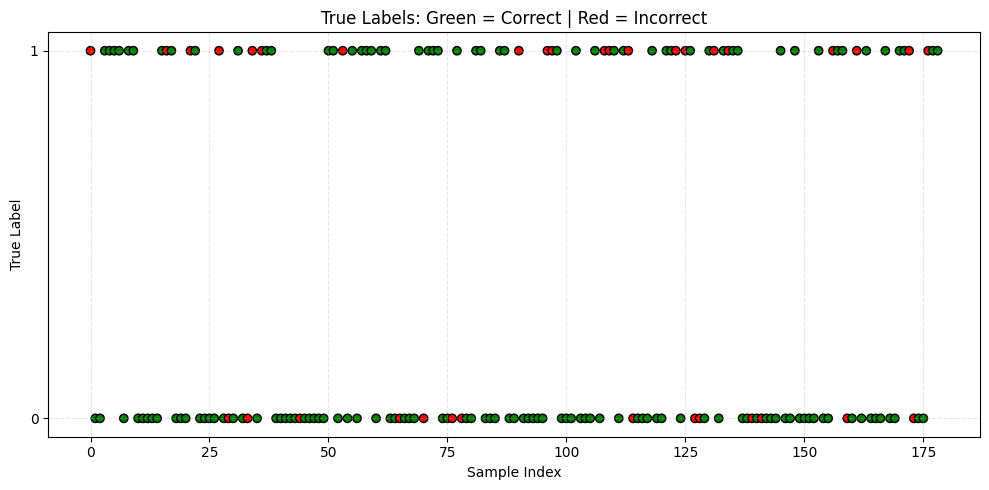

In [23]:
# Convert to numpy arrays if needed
y_true = np.array(y_test)
y_pred = np.array(y_pred)

# Create an array for the index (or sample number)
indices = np.arange(len(y_true))

# Define colors: green for correct, red for incorrect
colors = ['green' if yt == yp else 'red' for yt, yp in zip(y_true, y_pred)]

plt.figure(figsize=(10, 5))
plt.scatter(indices, y_true, c=colors, marker='o', edgecolor='black', label='True Label')

plt.xlabel('Sample Index')
plt.ylabel('True Label')
plt.title('True Labels: Green = Correct | Red = Incorrect')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### **Conclusion**

In this notebook, we implemented logistic regression from scratch, gaining a deeper understanding of its mathematical foundation, particularly the use of the logistic function and gradient ascent to maximize the likelihood. Through manual implementation, we explored how model coefficients are iteratively updated to improve prediction accuracy.

We also covered essential data preprocessing steps, including splitting data into training and testing sets, imputing missing values with tailored imputers, encoding categorical variables, and standardizing numerical features—highlighting the importance of applying transformations consistently between train and test datasets.

Finally, we evaluated our model using detailed performance metrics(macro-averaged), which provided comprehensive insight into the classifier’s behavior on different classes. Visualization of prediction accuracy further reinforced understanding of model performance.

This hands-on approach not only reinforces theoretical concepts but also equips us with practical skills to build, evaluate, and refine logistic regression models in real-world scenarios.